# ARRYTHMIA CLASSIFICATION of two Lead ECG signals using Deep Learning



# **Imports**

In [53]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [54]:
! pip install wfdb
! pip install scikeras
! pip install wget
! apt install unzip
! pip install ecg-plot 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
unzip is already the newest version (6.0-21ubuntu1.1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Importing all the packages needed for this project

In [114]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras import layers
import numpy as np
import os
import sys
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from keras.utils.np_utils import to_categorical
import wfdb
import tarfile
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import StratifiedKFold
from keras_preprocessing.sequence import pad_sequences
import math
import warnings
import wget
from keras import utils
from keras.models import Sequential,Model,load_model
from keras.layers import Dense, LSTM, CuDNNLSTM,CuDNNGRU
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import losses
from keras.callbacks import Callback
import keras.backend
from keras.layers import Dropout
from scikeras.wrappers import KerasClassifier
from sklearn.preprocessing import LabelEncoder
import scipy.stats as stats

Loading in 12 lead Data

In [100]:
from wfdb.io import annotation

def load_data(sample_path):
    sig, fields = wfdb.rdsamp(sample_path)

    return sig, fields
    

# Feature Description

**Primary** **Features**

This dataset contains 1425 ECG recordings from different patients. The data is given in the form of native python waveform-database format(WFDB). There are three file types:



1.   Header Files (.hea)
2.   Signal Files (.dat)
2.   Atrribute Files (.atr)













Downloading data from physionet website

In [102]:
url = 'https://physionet.org/static/published-projects/cpsc2021/paroxysmal-atrial-fibrillation-events-detection-from-dynamic-ecg-recordings-the-4th-china-physiological-signal-challenge-2021-1.0.0.zip'
filename = wget.download(url)


Unzipping Data

In [105]:
import zipfile
zip = zipfile.ZipFile(filename)
zip.extractall()

# Working with 2 Lead Data

Example 2 Lead Data

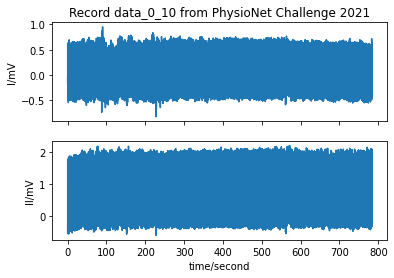

{'record_name': 'data_0_10',
 'n_sig': 2,
 'fs': 200,
 'counter_freq': None,
 'base_counter': None,
 'sig_len': 156768,
 'base_time': None,
 'base_date': None,
 'comments': ['non atrial fibrillation'],
 'sig_name': ['I', 'II'],
 'p_signal': array([[-0.04867337, -0.27253734],
        [-0.05505853, -0.30568262],
        [-0.04101658, -0.27356643],
        ...,
        [ 0.03760755,  0.00368757],
        [ 0.02562183, -0.00587439],
        [ 0.04891687,  0.00913317]]),
 'd_signal': None,
 'e_p_signal': None,
 'e_d_signal': None,
 'file_name': ['data_0_10.dat', 'data_0_10.dat'],
 'fmt': ['16', '16'],
 'samps_per_frame': [1, 1],
 'skew': [None, None],
 'byte_offset': [None, None],
 'adc_gain': [36960.66594624795, 23321.574588417934],
 'baseline': [-2430, -18661],
 'units': ['mV', 'mV'],
 'adc_res': [16, 16],
 'adc_zero': [0, 0],
 'init_value': [-4229, -25017],
 'checksum': [41165, 7554],
 'block_size': [0, 0]}

In [113]:
record = wfdb.rdrecord("./paroxysmal-atrial-fibrillation-events-detection-from-dynamic-ecg-recordings-the-4th-china-physiological-signal-challenge-2021-1.0.0/Training_set_I/data_0_10")
wfdb.plot_wfdb(record= record, title='Record data_0_10 from PhysioNet Challenge 2021') 
display(record.__dict__)


In [60]:
two_Leaddf = pd.DataFrame(record.p_signal, columns=['Lead I','Lead II'])
two_Leaddf.head(10)

,Lead I,Lead II
0,-0.048673,-0.272537
1,-0.055059,-0.305683
2,-0.041017,-0.273566
3,-0.026650,-0.251998
4,-0.044020,-0.263962
5,-0.083873,-0.304182
6,-0.080978,-0.319232
7,-0.080004,-0.326307
8,-0.072591,-0.315330
9,-0.163904,-0.380506


**Visualising 2 Lead Data**

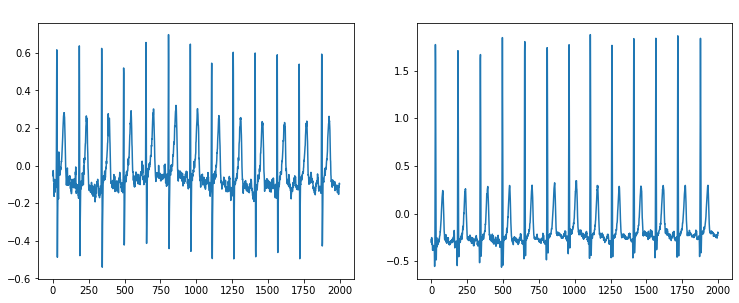

In [61]:
two_Leaddf_short = two_Leaddf[0:2000]
plt.figure(figsize=(26, 16))
for i, col in enumerate(two_Leaddf_short.columns[0:]):
    plt.subplot(3, 4, i + 1)
    plt.plot(two_Leaddf_short[col])
    plt.title(col, color = "white")

# Loading in all files

In [62]:
path = '/content/drive/MyDrive/paroxysmal-atrial-fibrillation/'
# loading record names
record_names = []
record_path = []
with open(path + 'RECORDS') as my_file:
  for line in my_file:
    record_path.append(line.rstrip("\n"))
    sp_line = line.split('/')
    record_names.append(sp_line[1].rstrip("\n"))

In [63]:
header_data = []
signal_data = np.zeros([1425,5000,2])
for i in range(len(record_path)): 
  data, h_data = load_data(path+record_path[i])
  if len(data) < 5000:
    arr = np.zeros([5000,2])
    arr[0:len(data)] = data
    signal_data[i] = arr
  else:
    signal_data[i] = data[0:5000]
  header_data.append(h_data)

# Data Preprocessing


**Signal** **Processing**

In this section we are going to be adding gaussian noise to our signals as well as normalisation using the z-score method.

In [64]:
X = np.array(signal_data, dtype=object)
X = X.reshape(1425,5000,2)
noise = np.random.normal(0, .1, X.shape)
noise_X = X + noise

In [65]:
X = stats.zscore(noise_X.astype(float), axis=None)
X.shape

(1425, 5000, 2)

**Cleaning Our Labels**

In this section we are cleaning the removing the diagnosis which are going to be our labels from inside the arrays for each column and replacing all the spaces with '-' 

In [66]:
y = pd.DataFrame(header_data)  # Converting our header data to a dataframe

In [67]:
y['str_comments'] = y.loc[:,'comments'].str[0]
y['str_comments'] = y['str_comments'].str.replace(' ', '-') #'replacing the spaces in our header data'

Plotting the distribution of our dataset, we can clearly see that this data is unbalanced from this diagram

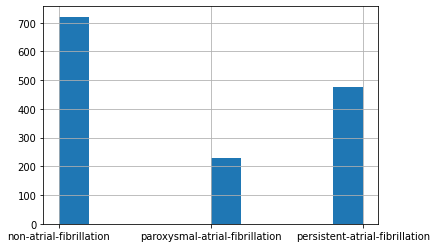

In [68]:
y['str_comments'].hist()

In [69]:
print('The shortest signal in our dataset is: ' +  str(y['sig_len'].min()))
print('The shortest signal in our dataset is: ' +  str(y['sig_len'].max()))

The shortest signal in our dataset is: 1675
The shortest signal in our dataset is: 4933325


Encoding our diagnosis for training

In [70]:
from sklearn.preprocessing import LabelEncoder
encode_df = LabelEncoder()
encode_df.fit(y.str_comments)
encoded_y = encode_df.transform(y.str_comments)
print("Total number of unique combinations of diagnosis: {}".format(len(np.unique(encoded_y))))

Total number of unique combinations of diagnosis: 3


# LSTM Model

In [71]:
def LSTM_model(learn_rate = 0.001, momentum = 0.8): 
  model = Sequential()
  model.add(CuDNNLSTM(512, input_shape =(signal_data[0].shape), return_sequences=True))
  model.add(Dropout(0.25))
  model.add(CuDNNLSTM(256, return_sequences=True)) 
  model.add(Dropout(0.2))
  model.add(CuDNNLSTM(128, return_sequences=True))
  model.add(Dropout(0.2))
  model.add(CuDNNLSTM(64))
  model.add(Dense(3, activation='sigmoid'))
  optimizer = tf.keras.optimizers.SGD(learning_rate=learn_rate, momentum = momentum)
  model.compile(loss='MSE', optimizer=optimizer, metrics=['accuracy','categorical_accuracy',"categorical_crossentropy"])
  model.summary()
  return model


# Splitting Data using Stratified K Fold

In [72]:
data_for_crossval= list(StratifiedKFold(n_splits=3, shuffle=True, random_state=42).split(X, y.str_comments))
X_opt = X[data_for_crossval[0][1]]
y_opt_skf = encoded_y[data_for_crossval[0][1]]
y_opt= to_categorical(y_opt_skf)

In [73]:
model = KerasClassifier(model=LSTM_model, verbose=1, epochs = 10, batch_size = 10)
print("Done")

Done


In [74]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=3)

# Hyper Parameter Optimization

In [75]:
# from sklearn.model_selection import GridSearchCV
# epochs = [5,10,15,20,50, 100]
# batches = [5,10,15,20]
# param_grid = dict(epochs=epochs, batch_size=batches)
# grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=skf.split(X_opt, y_opt_skf) , error_score='raise')
# grid_result = grid.fit(X_opt, y_opt)

In [76]:
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))

# Model Training

In [77]:
model = LSTM_model()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cu_dnnlstm_8 (CuDNNLSTM)    (None, 5000, 512)         1056768   
                                                                 
 dropout_6 (Dropout)         (None, 5000, 512)         0         
                                                                 
 cu_dnnlstm_9 (CuDNNLSTM)    (None, 5000, 256)         788480    
                                                                 
 dropout_7 (Dropout)         (None, 5000, 256)         0         
                                                                 
 cu_dnnlstm_10 (CuDNNLSTM)   (None, 5000, 128)         197632    
                                                                 
 dropout_8 (Dropout)         (None, 5000, 128)         0         
                                                                 
 cu_dnnlstm_11 (CuDNNLSTM)   (None, 64)               

In [78]:
y_new= to_categorical(encoded_y)
data_for_train_and_test= list(StratifiedKFold(n_splits=3, shuffle=True, random_state=42).split(X, y.str_comments))

In [79]:
X_test = X[data_for_train_and_test[0][1]]
y_test = y_new[data_for_train_and_test[0][1]]
X_train = X[data_for_train_and_test[0][0]]
y_train = y_new[data_for_train_and_test[0][0]]
x_train = np.asarray(X_train).astype(np.float32)
x_test =  np.asarray(X_test).astype(np.float32)

y_test=np.argmax(y_test, axis=1)

In [80]:
history = model.fit(x_train,y_train,batch_size = 5, epochs = 10)

Epoch 1/10
190/190 [==============================] - 80s 408ms/step - loss: 0.2183 - accuracy: 0.5295 - categorical_accuracy: 0.5295 - categorical_crossentropy: 0.9786
Epoch 2/10
190/190 [==============================] - 78s 410ms/step - loss: 0.1730 - accuracy: 0.7200 - categorical_accuracy: 0.7200 - categorical_crossentropy: 0.7883
Epoch 3/10
190/190 [==============================] - 78s 413ms/step - loss: 0.1501 - accuracy: 0.7358 - categorical_accuracy: 0.7358 - categorical_crossentropy: 0.6964
Epoch 4/10
190/190 [==============================] - 79s 414ms/step - loss: 0.1397 - accuracy: 0.7358 - categorical_accuracy: 0.7358 - categorical_crossentropy: 0.6669
Epoch 5/10
190/190 [==============================] - 79s 414ms/step - loss: 0.1344 - accuracy: 0.7358 - categorical_accuracy: 0.7358 - categorical_crossentropy: 0.6593
Epoch 6/10
190/190 [==============================] - 79s 415ms/step - loss: 0.1314 - accuracy: 0.7358 - categorical_accuracy: 0.7358 - categorical_crossen

# Plot Training Information

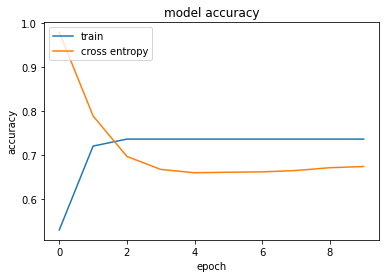

In [81]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['categorical_crossentropy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'cross entropy'], loc='upper left')
plt.show()

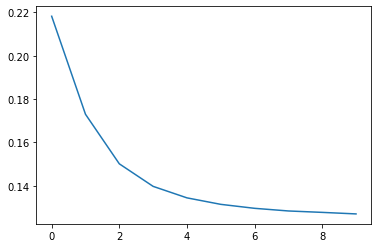

In [82]:
plt.plot(history.history['loss'])

In [83]:
y_pred = model.predict(x_test)

In [84]:
len(y_pred)

475

In [85]:
from sklearn.metrics import ConfusionMatrixDisplay
import seaborn as sns


In [86]:
def visualise(test, pred):
  pred =np.argmax(pred, axis=1)

  cm = confusion_matrix(test, pred)

  cm_df = pd.DataFrame(cm,
                     index = ['non-atrial-fibrillation','persistent-atrial-fibrillation','paroxysmal-atrial-fibrillation'], 
                     columns = ['non-atrial-fibrillation','persistent-atrial-fibrillation','paroxysmal-atrial-fibrillation'])
  plt.figure(figsize=(5,4))
  sns.heatmap(cm_df, annot=True, fmt='g')
  plt.title('Confusion Matrix')
  plt.ylabel('Actual Values')
  plt.xlabel('Predicted Values')
  plt.show()

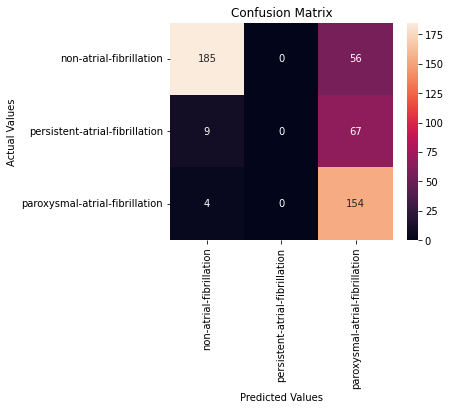

In [87]:
visualise(y_test, y_pred)

In [88]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
def metrics(test, pred):

    pred=np.argmax(pred, axis=1)
    print('Precision: %.3f' % precision_score(test, pred,average='weighted'))
    print('Recall: %.3f' % recall_score(test, pred, average='weighted'))
    print('Accuracy: %.3f' % accuracy_score(test, pred))
    print('F1 Score: %.3f' % f1_score(test, pred, average='weighted'))

In [89]:
metrics(y_test, y_pred)

Precision: 0.659
Recall: 0.714
Accuracy: 0.714
F1 Score: 0.663


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Training using GRU Model

In [90]:
def GRU_Model(learn_rate = 0.001, momentum = 0.8):
  model = Sequential()
  model.add(CuDNNGRU(512, input_shape =(signal_data[0].shape), return_sequences=True))
  model.add(Dropout(0.2))
  model.add(CuDNNGRU(256, return_sequences=True))
  model.add(Dropout(0.2))
  model.add(CuDNNGRU(128 , return_sequences=True))
  model.add(Dropout(0.2))
  model.add(CuDNNGRU(64))
  model.add(Dense(3, activation='softmax'))
  optimizer = tf.keras.optimizers.SGD(learning_rate=learn_rate, momentum = momentum)
  model.compile(loss='MSE', optimizer=optimizer, metrics=['accuracy','categorical_accuracy',"categorical_crossentropy"])
  model.summary()
  return model

In [91]:
g_model = GRU_Model()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cu_dnngru (CuDNNGRU)        (None, 5000, 512)         792576    
                                                                 
 dropout_9 (Dropout)         (None, 5000, 512)         0         
                                                                 
 cu_dnngru_1 (CuDNNGRU)      (None, 5000, 256)         591360    
                                                                 
 dropout_10 (Dropout)        (None, 5000, 256)         0         
                                                                 
 cu_dnngru_2 (CuDNNGRU)      (None, 5000, 128)         148224    
                                                                 
 dropout_11 (Dropout)        (None, 5000, 128)         0         
                                                                 
 cu_dnngru_3 (CuDNNGRU)      (None, 64)               

In [92]:
GRU_history = g_model.fit(x_train,y_train, batch_size = 5, epochs = 10)

Epoch 1/10
190/190 [==============================] - 76s 375ms/step - loss: 0.1756 - accuracy: 0.7316 - categorical_accuracy: 0.7316 - categorical_crossentropy: 0.9026
Epoch 2/10
190/190 [==============================] - 71s 375ms/step - loss: 0.1340 - accuracy: 0.7358 - categorical_accuracy: 0.7358 - categorical_crossentropy: 0.7229
Epoch 3/10
190/190 [==============================] - 71s 375ms/step - loss: 0.1275 - accuracy: 0.7358 - categorical_accuracy: 0.7358 - categorical_crossentropy: 0.6850
Epoch 4/10
190/190 [==============================] - 71s 375ms/step - loss: 0.1253 - accuracy: 0.7358 - categorical_accuracy: 0.7358 - categorical_crossentropy: 0.6698
Epoch 5/10
190/190 [==============================] - 71s 375ms/step - loss: 0.1250 - accuracy: 0.7358 - categorical_accuracy: 0.7358 - categorical_crossentropy: 0.6665
Epoch 6/10
190/190 [==============================] - 71s 376ms/step - loss: 0.1244 - accuracy: 0.7358 - categorical_accuracy: 0.7358 - categorical_crossen

# Prediction and Visualisation using GRU Model

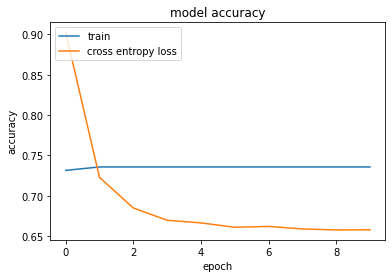

In [93]:
plt.plot(GRU_history.history['accuracy'])
plt.plot(GRU_history.history['categorical_crossentropy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'cross entropy loss'], loc='upper left')
plt.show()

In [94]:
GRU_pred = g_model.predict(x_test)

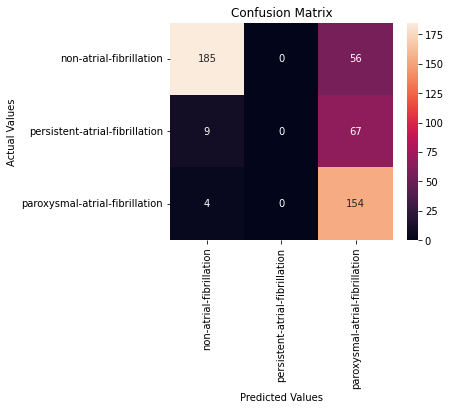

In [95]:
visualise(y_test, GRU_pred)

In [96]:
metrics(y_test, GRU_pred)

Precision: 0.659
Recall: 0.714
Accuracy: 0.714
F1 Score: 0.663


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
